<a href="https://colab.research.google.com/drive/13na-qaRSMwD2jplXjg_oapPDmVozIzLL?usp=sharing#scrollTo=600c8aa4" target="_blank"><img align="left" alt="Colab" title="Open in Colab" src="https://colab.research.google.com/assets/colab-badge.svg"></a>

<a href="https://www.kaggle.com/code/ritvik1909/variational-auto-encoder" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Variational Auto Encoder (VAE) -MNIST Augmentation

In this notebook we will be using a variational autoencoder to augment MNIST digit images

Just as a standard autoencoder, a variational autoencoder is an architecture composed of both an encoder and a decoder and that is trained to minimise the reconstruction error between the encoded-decoded data and the initial data. However, in order to introduce some regularisation of the latent space, we proceed to a slight modification of the encoding-decoding process: instead of encoding an input as a single point, we encode it as a distribution over the latent space. The model is then trained as follows:
* the input is encoded as distribution over the latent space
* a point from the latent space is sampled from that distribution
* the sampled point is decoded and the reconstruction error can be computed
* the reconstruction error is backpropagated through the network

source: [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)



In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from tqdm.auto import trange

## Utilities

In [ ]:
def plot_results(images, n_cols=None, title=None):
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    fig = plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
    plt.suptitle(title)

In [ ]:
BATCH_SIZE = 128
CODINGS_SIZE = 32
N_EPOCHS = 150

# Prepare the Dataset

Utility functions to create `tf.data.Dataset` objects for the images of a particular class (digit)

In [ ]:
def prepare_data(label, batch_size):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1)
    X_train = X_all[np.where(y_all == label)]

    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    
    return dataset

def prepare_images(label):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    X_all = X_all.astype(np.float32) / 255
    X_all = X_all.reshape(-1, 28, 28, 1) * 2. - 1.
    X_train = X_all[np.where(y_all == label)]
    
    return X_train

# Build the Model

Here we will define the componets we mentioned above
* Sampling Layer, to draw a point from the distribution
* Encoder, typically conssisting of Convolutional Layers and Max Pooling Layers
* Decoder, typically consisting of Transposed Convolutional Layers and Upsampling Layers

In [ ]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def build_encoder():
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    z_mean = keras.layers.Dense(CODINGS_SIZE, name="z_mean")(x)
    z_log_var = keras.layers.Dense(CODINGS_SIZE, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [ ]:
def build_decoder():
    latent_inputs = keras.Input(shape=(CODINGS_SIZE,))
    x = keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = keras.layers.Reshape((7, 7, 64))(x)
    x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

Lets define the training loop

The loss function that is minimised when training a VAE is composed of a “reconstruction term” (on the final layer), that tends to make the encoding-decoding scheme as performant as possible, and a “regularisation term” (on the latent layer), that tends to regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution. That regularisation term is expressed as the Kulback-Leibler divergence between the returned distribution and a standard Gaussian

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Encoder Summary


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                          

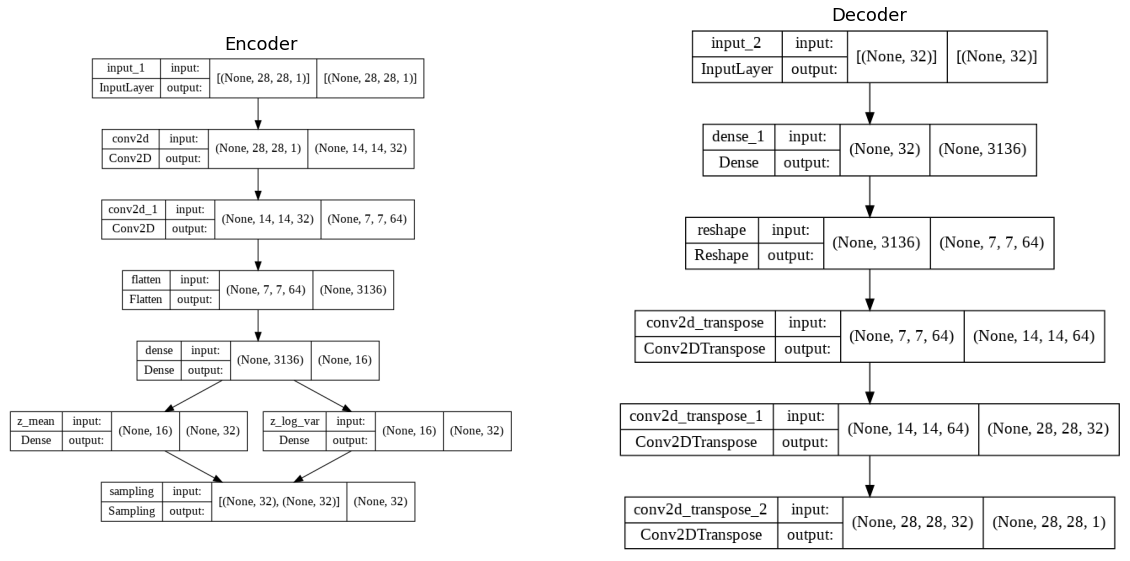

In [ ]:
encoder = build_encoder()
decoder = build_decoder()
print('Encoder Summary\n\n')
encoder.summary()
print('\n\nDecoder Summary\n\n')
decoder.summary()
keras.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')
keras.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder', fontsize=18)
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder', fontsize=18)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# VAE in Action

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/150
53/53 [==============================] - 16s 24ms/step - loss: 419.6296 - reconstruction_loss: 317.3820 - kl_loss: 6.2433
Epoch 2/150
53/53 [==============================] - 1s 19ms/step - loss: 222.0866 - reconstruction_loss: 212.9534 - kl_loss: 5.0688
Epoch 3/150
53/53 [==============================] - 1s 17ms/step - loss: 211.3697 - reconstruction_loss: 201.1579 - kl_loss: 6.1395
Epoch 4/150
53/53 [==============================] - 1s 17ms/step - loss: 196.1058 - reconstruction_loss: 181.4445 - kl_loss: 8.8613
Epoch 5/150
53/53 [==============================] - 1s 17ms/step - loss: 176.4591 - reconstruction_loss: 162.6104 - kl_loss: 10.3253
Epoch 6/150
53/53 [==============================] - 1s 17ms/step - loss: 167.5885 - reconstruction_loss: 154.2082 - kl_loss: 11.6385
Epoch 7/150
53/53 [==============================] - 1s 18ms/step - loss: 163.6942 - reconstruction_loss: 150.0354 - kl_loss: 12.2145


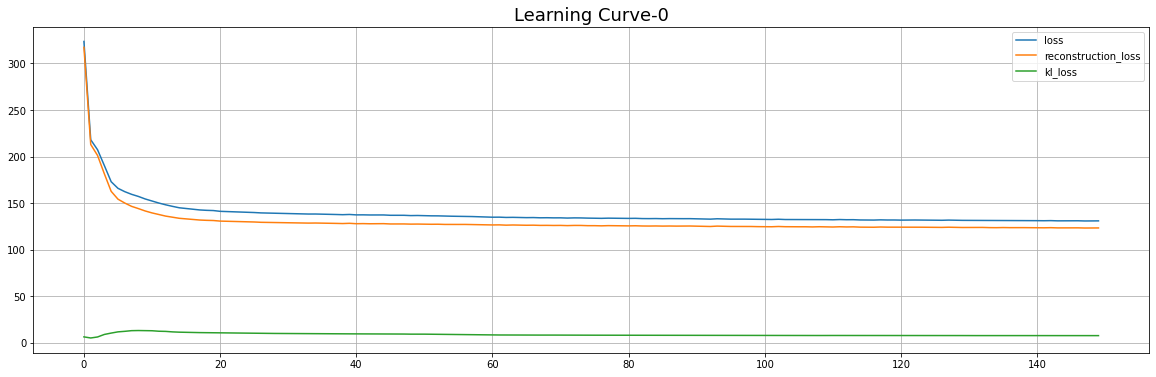

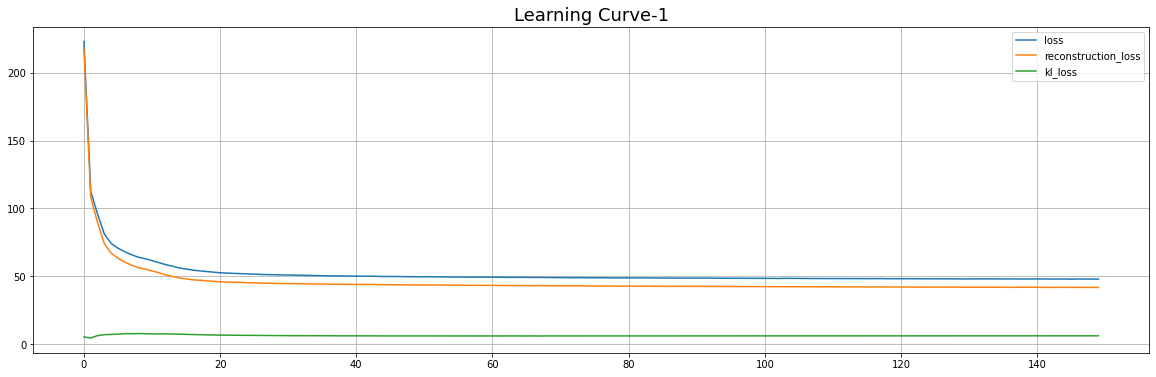

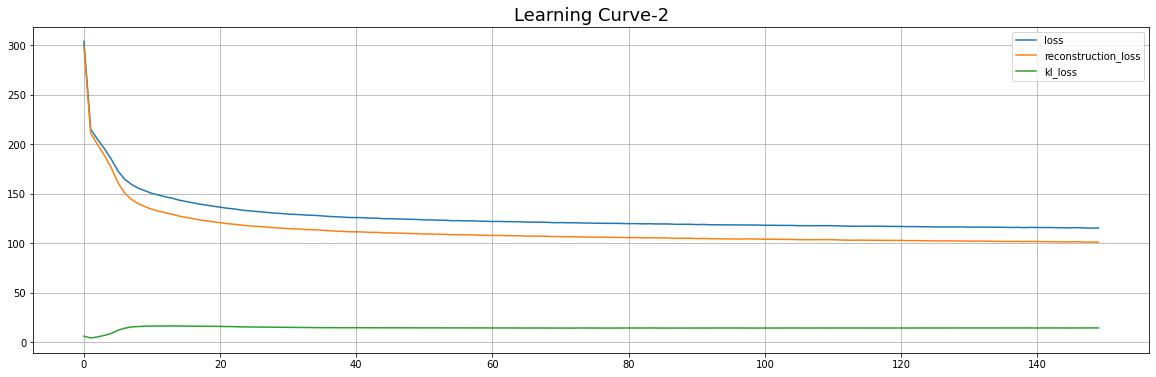

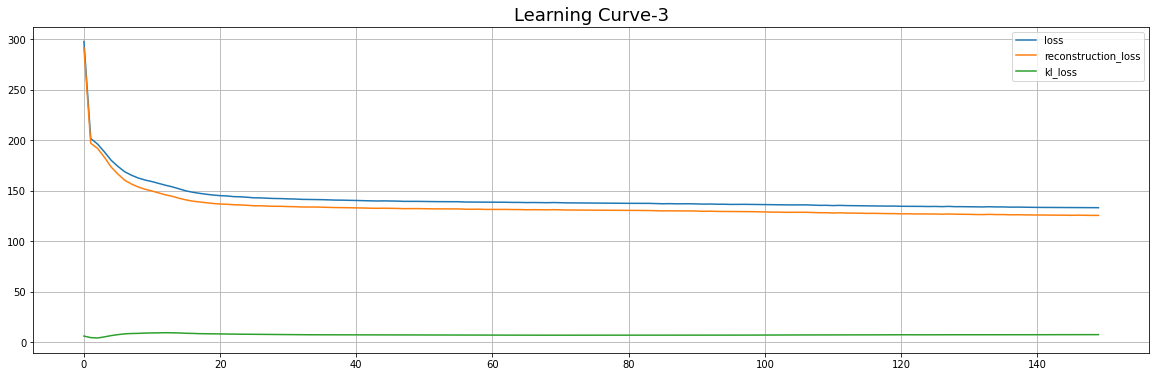

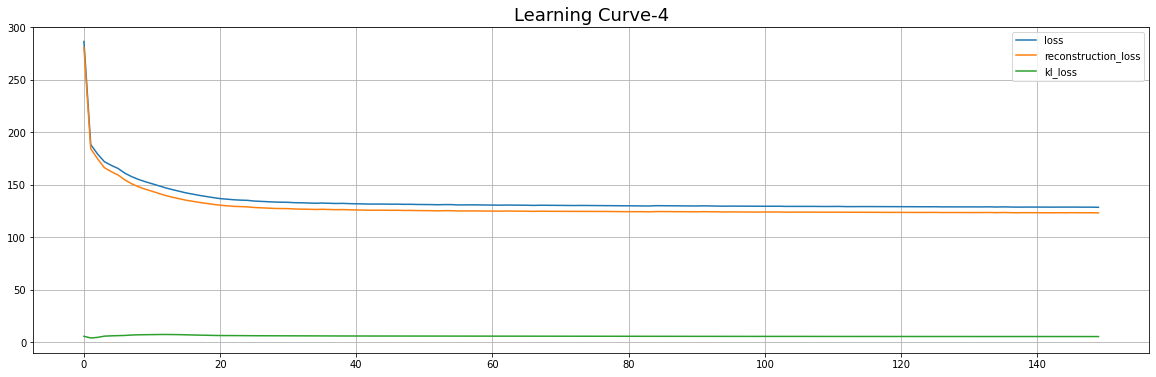

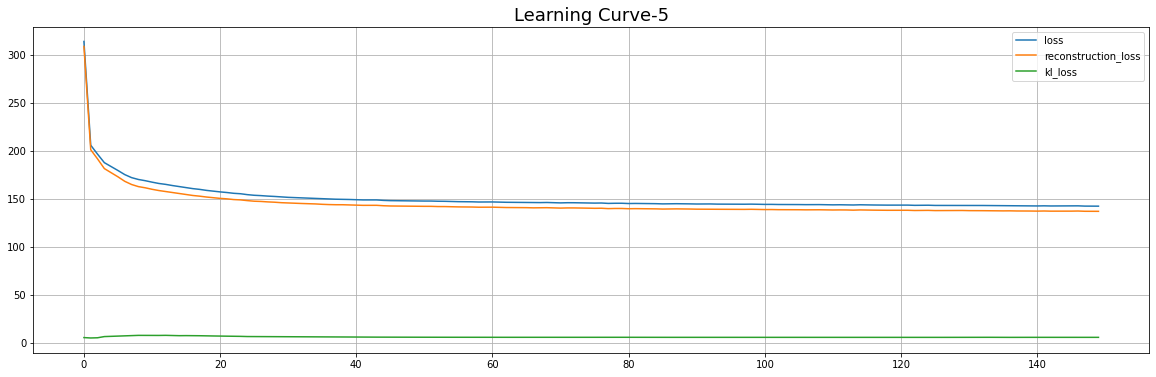

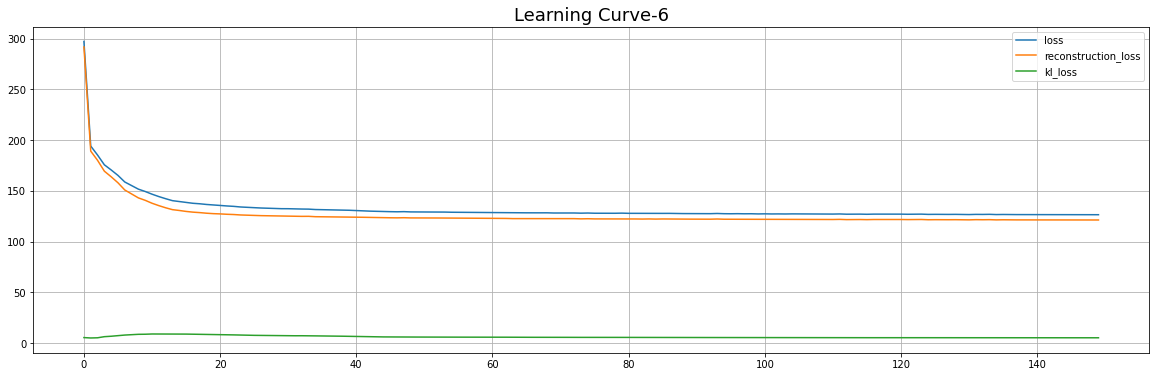

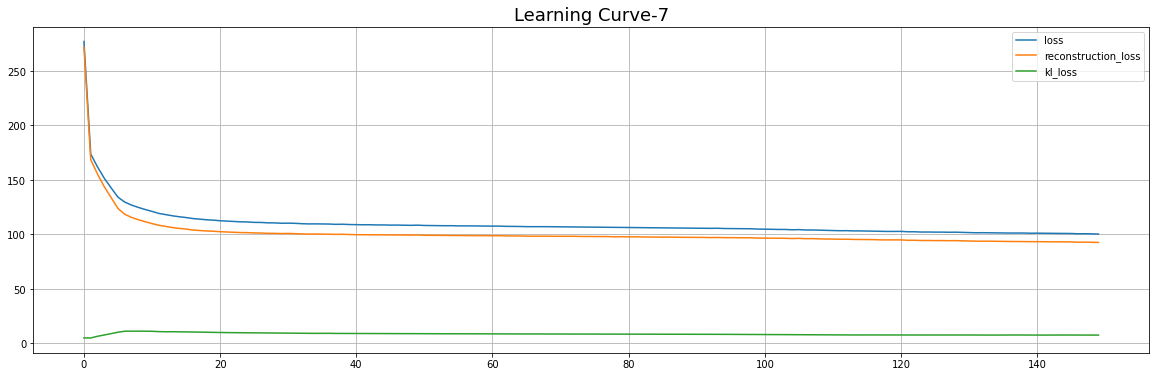

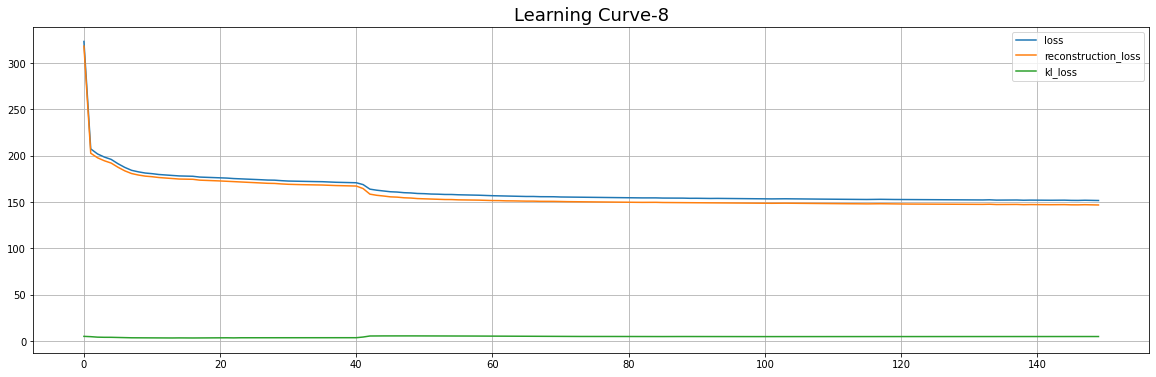

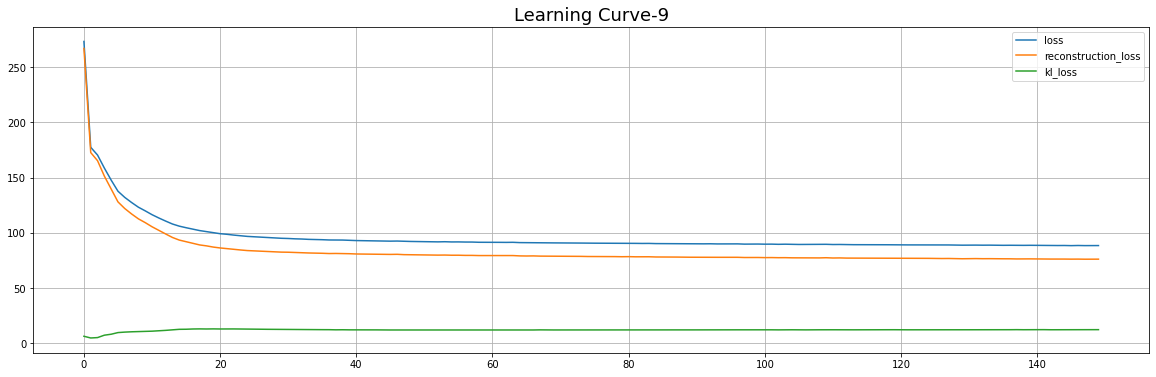

In [ ]:
for i in range(10):
    LABEL = i
    dataset = prepare_data(LABEL, BATCH_SIZE)

    encoder = build_encoder()
    decoder = build_decoder()
    
    gan = VAE(
        encoder=encoder, decoder=decoder, 
    )
    gan.compile(
        keras.optimizers.Adam(learning_rate=0.001),
    )
    
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Learning Curve-{LABEL}', fontsize=18)
    history = gan.fit(dataset, epochs=N_EPOCHS, verbose=1)
    pd.DataFrame(history.history).plot(ax=ax)
    ax.grid()
       
    decoder.save(f'MNIST-AUG-VAE-{LABEL}.h5')

# Generated Images

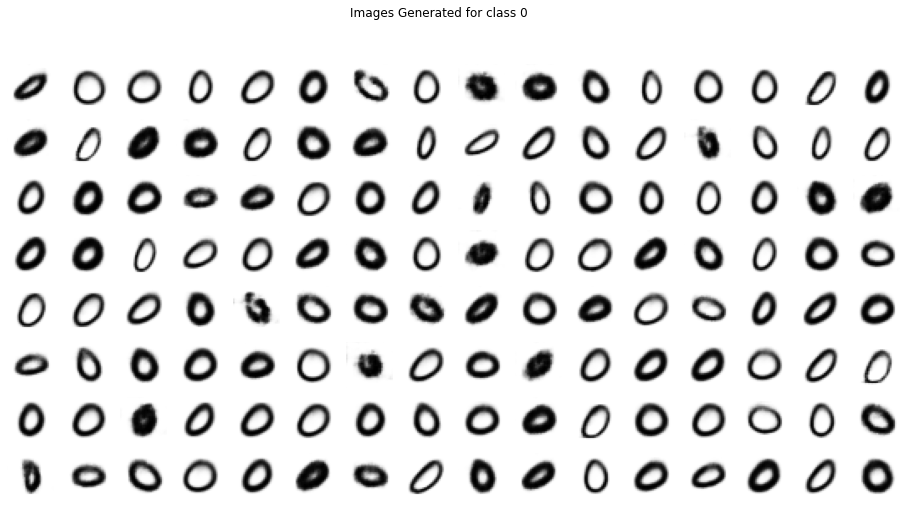

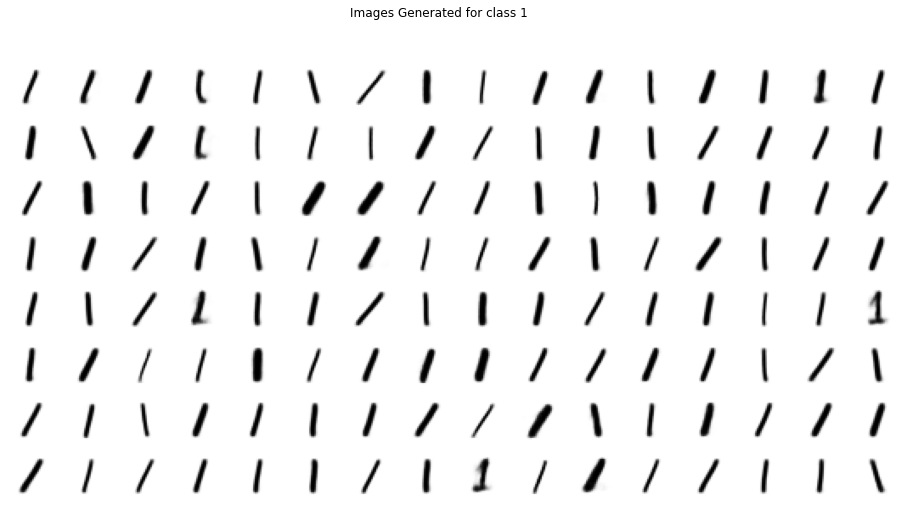

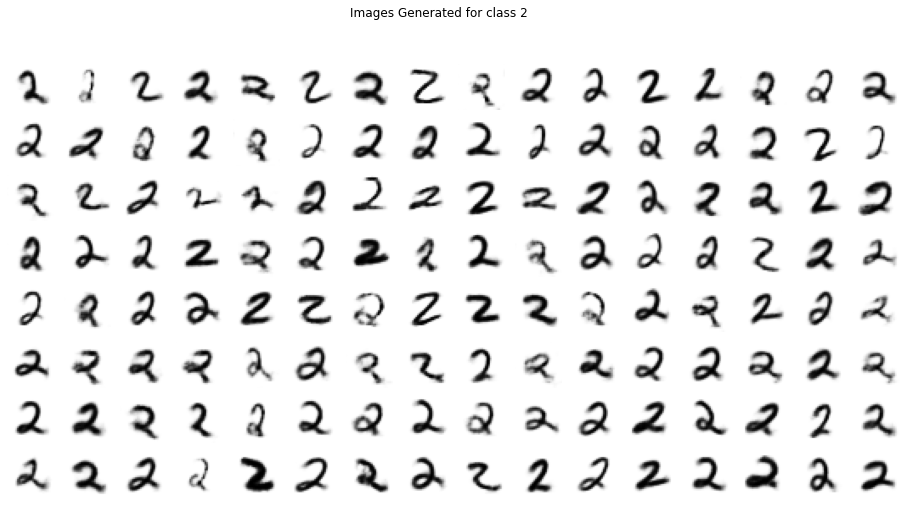

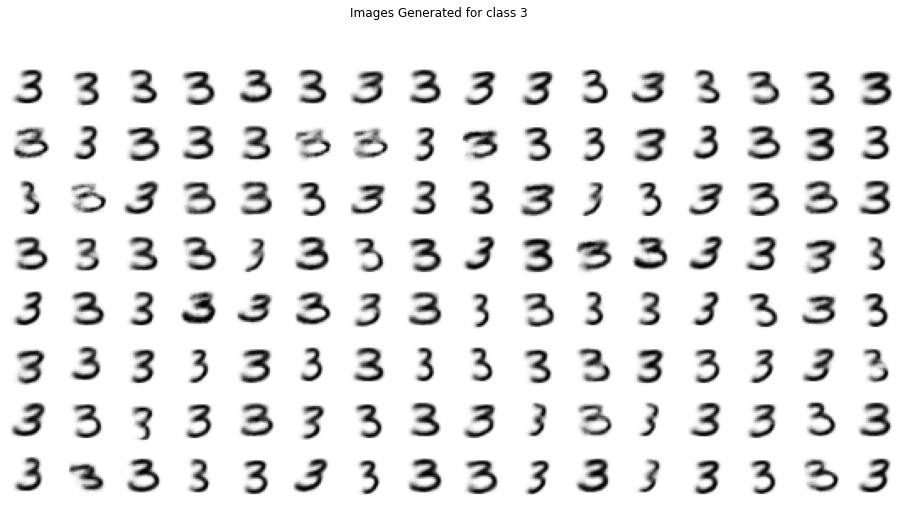

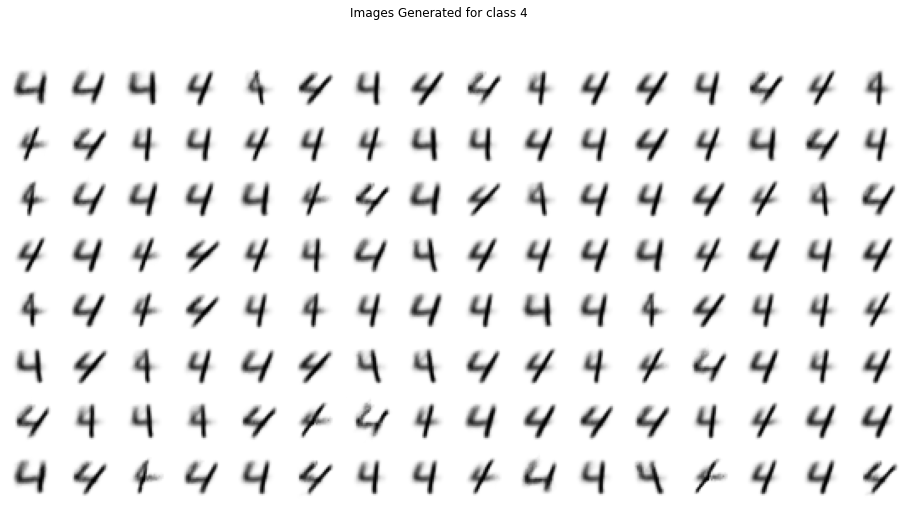

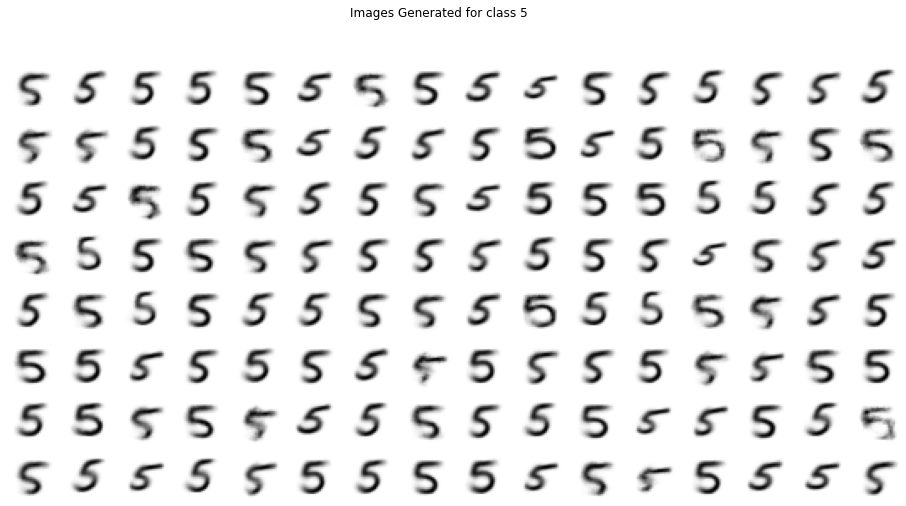

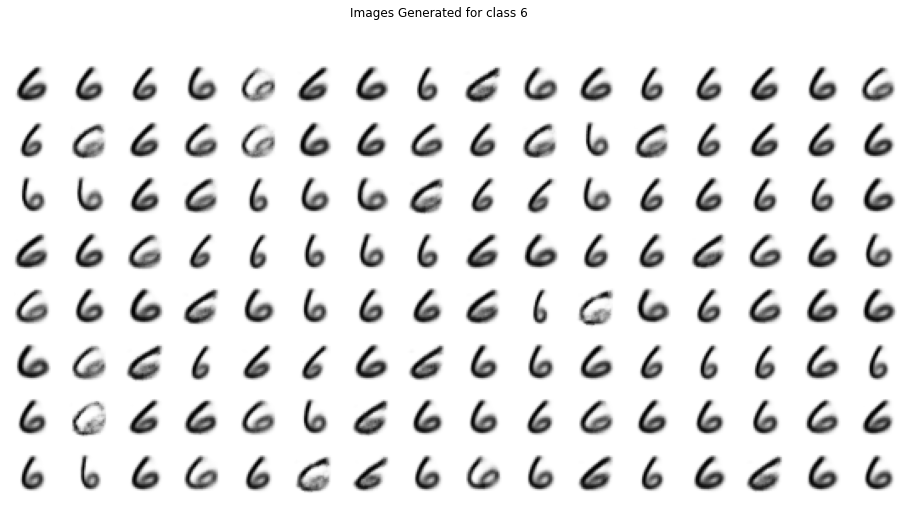

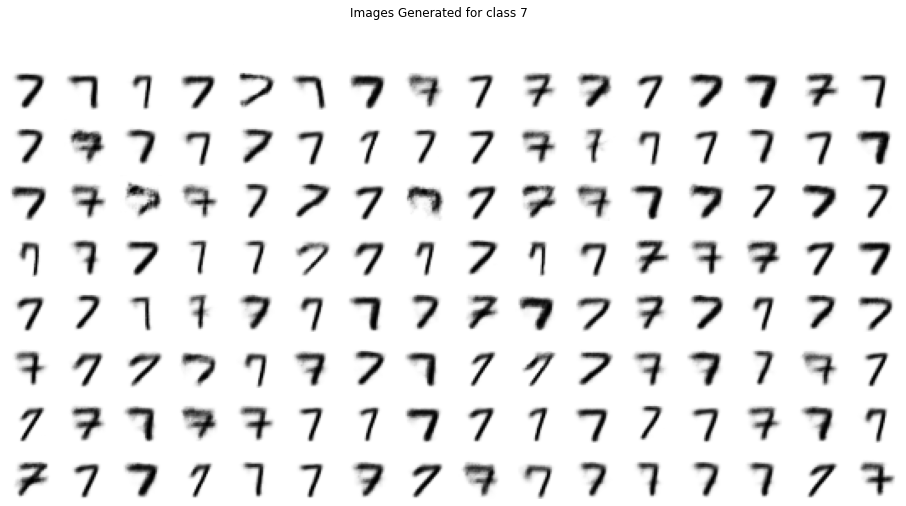

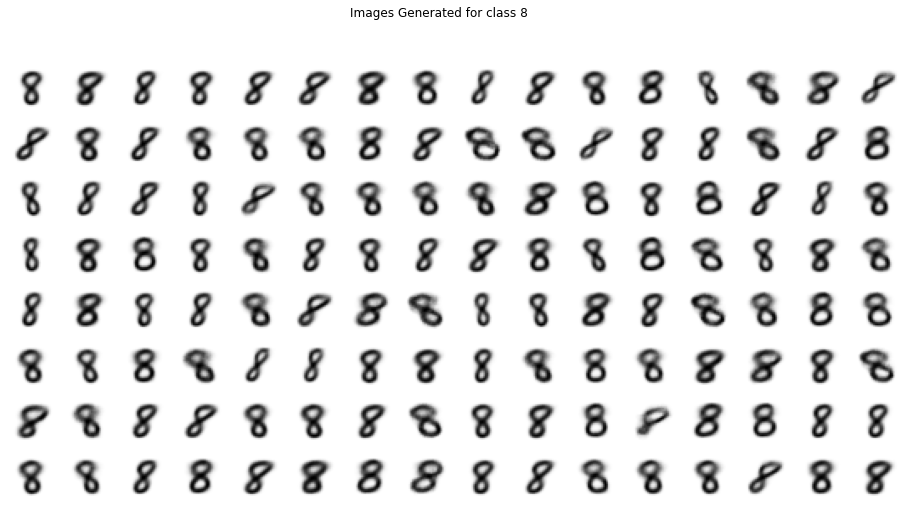

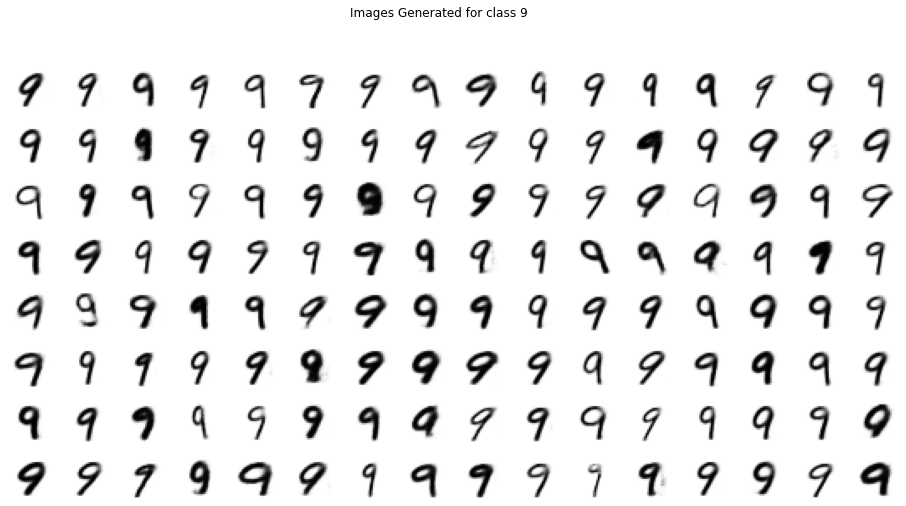

In [ ]:
for i in range(10):
    decoder = keras.models.load_model(f'MNIST-AUG-VAE-{i}.h5')
    fake_images = decoder(tf.random.normal([128, CODINGS_SIZE]))
    plot_results(fake_images, 16, f'Images Generated for class {i}')
    plt.show()